<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/Humour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
import requests
import pandas as pd

### Defining methods useful for scraping the Reddit threads


In [81]:
def scrape_url(url, pages=0):
  resp = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'limit': '100'})
  data = resp.json()
  data_list = []
  data_list.append(data)
  # if more than 100 data points are needed:
  if pages != 0:
    for i in range(pages):
      after_param = data['data']['after'] 
      data = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'after': after_param, 'limit': '100'})
      data_2 = data.json()
      data_list.append(data_2)
      data = data_2
  return data_list

def make_list_from_json(json_list):
  data = []
  for collection in json_list:
    collection_list = collection['data']['children']
    for joke_index in range(len(collection_list)):
      data.append(collection_list[joke_index]['data'])
  return data

def transform_data(data):
  df = pd.DataFrame(data)
  clean_df = pd.DataFrame()

  clean_df['title'] = df['title']
  clean_df['selftext'] = df['selftext']
  clean_df['ups'] = df['ups']
  clean_df['downs'] = df['downs']
  clean_df['upvote_ratio'] = df['upvote_ratio']
  clean_df['total_awards_received'] = df['total_awards_received']

  return clean_df

# Scraping r/dadjokes


In [82]:
url = "https://www.reddit.com/r/dadjokes.json"
data = scrape_url(url, 100)
data = make_list_from_json(data)

### Save only important columns in dataframe

In [83]:
clean_df = transform_data(data)

### Plot the stats of the reddit jokes

Number of jokes with upvotes different from zero:  9055
Number of jokes with no engagement:  609
Average number of upvotes:  232.33029801324503
Average upvote ratio:  0.8413990066225079


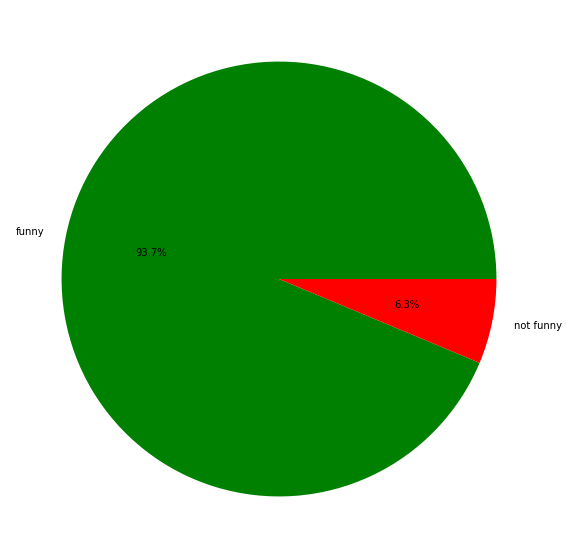

In [84]:
# print out as a pie chart how many jokes are funny or not
from matplotlib import pyplot as plt

# calculate number of posts with upvotes different grater than downvotes
funny = clean_df[clean_df['ups'] > clean_df['downs']]
# not_funny = clean_df[clean_df['ups'] <= clean_df['downs']]
no_engagement = len(clean_df[(clean_df['ups'] == 0) & (clean_df['downs'] == 0)])


#calculate how many have only upvotes and zero downvotes
upvotes_count = downvotes_count = 0
for index in range(len(clean_df)):
    if clean_df['ups'][index] > 0:
        upvotes_count += 1
    # elif clean_df['downs'][index] > 0:
    #     downvotes_count += 1

print("Number of jokes with upvotes different from zero: ", upvotes_count)
print("Number of jokes with no engagement: ", no_engagement)

treshhold_ups = clean_df['ups'].mean()
print("Average number of upvotes: ", treshhold_ups)
threshold_ratio = clean_df['upvote_ratio'].mean()
print("Average upvote ratio: ", threshold_ratio)


funny_percentage = len(funny) / len(clean_df) * 100
no_engagement_percentage = no_engagement / len(clean_df) * 100
# not_funny_percentage = len(not_funny) / len(clean_df) * 100

# set size of pie chart
plt.figure(figsize=(10,10))
plt.pie([funny_percentage, no_engagement_percentage], labels=['funny', 'not funny'], autopct='%1.1f%%', colors=['green', 'red'])
plt.show()

Experimenting to find a threshold 

In [85]:
unfunny_but_awarded = 0
funny = 0
count = 0
jokes_dataset = pd.DataFrame()
for index in range(len(clean_df)):

  if clean_df['ups'][index] > treshhold_ups and clean_df['upvote_ratio'][index] > threshold_ratio:
    jokes_dataset = jokes_dataset.append(clean_df.iloc[count])
    count = count + 1
    funny = funny + 1



print('total ', len(clean_df))
print('not that funny but have awards ', unfunny_but_awarded)
print('funny ', funny)
print('funny ratio ', funny/len(clean_df))

total  9664
not that funny but have awards  0
funny  681
funny ratio  0.07046771523178808


In [87]:
# add one more column to jokes_dataset with length of selftext
jokes_dataset['title_length'] = jokes_dataset['title'].apply(len)
jokes_dataset['selftext_length'] = jokes_dataset['selftext'].apply(len)
print("The highest length of title is ", jokes_dataset['title_length'].max())
print("The highest length og the joke is: ", jokes_dataset['selftext_length'].max())

The highest length of title is  260
The highest length og the joke is:  1778


In [88]:
# save jokes_dataset in a csv file
jokes_dataset.to_csv(f'reddit_funny_dadjokes({len(jokes_dataset)}).csv')

# Scraping r/badjokes


In [89]:
# Get reddit /r/badjokes data
url = "https://www.reddit.com/r/badjokes.json"
data_neg = scrape_url(url, 5)
data_neg = make_list_from_json(data_neg)

### Save only important columns in dataframe

In [90]:
badjokes_dataset = transform_data(data_neg)

In [91]:
print(len(badjokes_dataset))

600


In [92]:
# save jokes_dataset in a csv file
badjokes_dataset.to_csv(f'reddit_badjokes({len(badjokes_dataset)}).csv')

# Data Pre-processing - WIP

In [93]:
# merge punch line and joke
# add appropriate punctuation
jokes_dataset['joke'] = ''
for joke_index in range(len(jokes_dataset)):
  title = jokes_dataset['title'][joke_index]
  separator = ' '
  if title[len(title) - 1].isalpha():
      separator = '. '
  jokes_dataset['joke'][joke_index] = jokes_dataset['title'][joke_index] + separator + jokes_dataset['selftext'][joke_index] 
  joke = jokes_dataset['joke'][joke_index]
  if joke[len(joke) - 1].isalpha():
    jokes_dataset['joke'][joke_index] = joke + '.'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [97]:
normalised_jokes = []
for joke_index in range(len(jokes_dataset)):
  if jokes_dataset['title_length'][joke_index] + jokes_dataset['selftext_length'][joke_index] < 200:
    normalised_jokes.append(joke_index)
print(len(normalised_jokes))

649


### Experiment with similarity scores

In [98]:
from difflib import SequenceMatcher
max = 0
index_similar = 0
jokes_dataset['similarity'] = ''
for joke_index in range(len(jokes_dataset)):
  title = jokes_dataset['title'][joke_index]
  text = jokes_dataset['selftext'][joke_index]

  title_words = title.split()
  text_words = text.split()
  final_score = 0
  for title_word in title_words:
    for text_word in text_words:
      s = SequenceMatcher(None,title_word,text_word)
      match_freq = s.ratio()
      final_score += 1
  jokes_dataset['similarity'][joke_index] = final_score
  if final_score > max and joke_index in normalised_jokes:
    index_similar = joke_index
    max = final_score
print(jokes_dataset['joke'][index_similar])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


I went to get pizza the other day and they asked if I wanted it cut into eight slices. I told them there’s no way I can eat eight slices in one sitting and had them cut it into four.
